In [323]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
from pathlib import Path  # python3 only
import math,datetime
import itertools
import scipy.stats
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
state = 'Texas'
year = str(2021)
currentYear = datetime.datetime.now().year
trendAnalysis = pd.DataFrame(columns = ['Phrase','Frequency','Counties'])


## Getting Started
*keyWords is the list of words I'm looking to analyse and graph*


In [324]:
keyWords = ['China','mexican','hispanic','black people','immigrant','muslim','transgender','asian','chinese','gay']
# keyWords = ['hispanic']
# keyWords = ['muslim']
# keyWords = ['immigrant','transgender','muslim']

## Dataframe Construction
The below code is largely identical to the dataframe construction and graph dataframe construction code in the main notebook
Differences:
- I now slice up the main dataframe into a matrix
- The columns correspond to keywords, and the rows correspond to the year. Each cell is the sentiment at that point with its annual mentions

In [325]:
averageSentKeyword = {}
mentionsKeyword = {}
maxTweets = []
maxSentiment = []
# MENTIONSKEYWORD is the frequency of mentions year by year of the given term
startYear = 2010
# Start year is the year you want to begin construction of the graph
yearList = []

county = input("Enter the County (Type Nothing for State) ").upper()
# county = 'COLLIN'
for year in range(startYear,currentYear+1):
    year = str(year)
    yearList.append(int(year))
for keyword in keyWords:
    
    averageSentimentOverTime = []
    json_folder = 'Keyword State'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    # stateDF = stateDF[[0,1,2]]
    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score',2:'Time'}, inplace=True)
    timeDF = pd.json_normalize(stateDF['Time'])
    stateDF.drop('Time',axis = 1,inplace= True)
    maxCount = timeDF[list(timeDF.filter(regex=('count')))].max().max()
    for year in range(startYear,currentYear+1):
        year = str(year)
        totalTweets=0
        if(len(list(timeDF.filter(regex=year)))>0):
            
            slicetimeDF = timeDF[list(timeDF.filter(regex=('County|' + year+'.comp|' + year+'.count')))]
            # county=timeDF[list(timeDF.filter(regex=('County|' + year+'.count')))]
            # print(county)
            stateDF = pd.concat([stateDF['County'], slicetimeDF], axis=1)
            stateDF.rename(columns= {stateDF.columns[1]:'# of Tweets',stateDF.columns[2]:'score'}, inplace=True)
            json_folder = 'Keyword State'
            file_dir = Path.cwd()
            file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))

            # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
            f = open(file_path, 'r')
            score = []
            j=0

            #-------------------------------------
            #-------------------------------------
            # AVERAGE SENT. AND TOTAL POP.
            # get the sum of all values in a column
            
            # Get the row with the term of the county in it
            countyDF = (stateDF.loc[stateDF['County'] == county])
            


            # By replacing the totalTweets, we should get the county info at that time
            if county == '':
                totalTweets = stateDF.iloc[:, 1].sum()
                averageSentiment = 0
                k=0
                for score in stateDF['score']:
                    if(math.isnan(score)==False):
                        # multiply all values in the score column by the corresponding value in the population column
                        averageSentiment += score * stateDF.iat[k,1]
                    k+=1
                averageSentiment=averageSentiment/totalTweets
                
                averageSentimentOverTime.append([averageSentiment,int(year)])
            # by replacing averageSentiment with the county info at that time, we can switch this easy


            # Average sentiment overtime is a single index for a specific keyword, which then gets dumped into averageSentKeyword
            else:
                index = countyDF.index.values.tolist()[0]
                totalTweets = sentiment = countyDF.at[index,'# of Tweets']
                
                sentiment = countyDF.at[index,'score']
                
                averageSentimentOverTime.append([sentiment,int(year)])
        
        # totalTweets = stateDF.iloc[:, 1].sum()
        if keyword in mentionsKeyword:
            mentionsKeyword[keyword].append([totalTweets,int(year)])
        else:
            mentionsKeyword[keyword] = [[totalTweets,int(year)]]
        maxTweets.append(totalTweets)
        
    
    a, b = zip(*averageSentimentOverTime)
    maxSentiment.append(a)
    averageSentKeyword[keyword] = a





#### Sorting and Naming the matrix
*Deconstructing previous dictionaries used for sorting, and creating the matrix with named rows and columns*

In [326]:
SentimentYear = {}
topKeys = averageSentKeyword.keys()
for i in range(len(averageSentKeyword.values())):
    # averageSentKeyword.values()[i]
    sentiment = list(list(averageSentKeyword.values())[i])
    for j in range(len(yearList)):
        if yearList[j] in SentimentYear:
            
            SentimentYear[yearList[j]].append(list(sentiment)[j])
        else:
            SentimentYear[yearList[j]] = [list(sentiment)[j]]
            # Sentiment year is the sorted matrix which is passed through the normalizing function
            # The columns are a measure of the given year
            # The rows are the different keywords
topKeys = list(topKeys)
# normalizedSentiment =  scaler.fit_transform(list(SentimentYear.values()))
NormalizedData =pd.DataFrame(SentimentYear.values(),index=SentimentYear.keys(),columns=topKeys)

Splitting up the matrix to be iterated through

In [327]:

# NormalizedData.rename(topKeys,inplace=True)
remappedData = []
for i in range(len(NormalizedData.columns)):
    testData = NormalizedData[[topKeys[i]]].values.tolist()
    a = testData
    a=list(a)
    remappedData.append(list(a))

## Correlation Checker
Takes an input of a pair of words, and checks for correlation in their data
- The function splits up the pair, and defines its group of y points as the sentiment value. the x points are the mentions
- From here, the arrays are checked to see if any of them have missing data. 
    - if one list is missing a year's data, every set of x's and y'x will have that datapoint dropped, (including the year).
- After that has occured, the size of the data is set to the dataset with the minimum length (explicit vs implicit)

- Once all the lists are NaN free and of the same size, they are run through pearsonr, and it returns the analysis of both the sentiment data, and the mentions data
- If the lists have less than 6 datapoints, NaN's are returned

In [328]:
from scipy.stats.stats import pearsonr
# The phrases muslim,transgender,and immigrant are STRONGLY correlated, with the max distance between muslim and immigrant,minimum distance between immigrant and transgender
def correlationWords(words):
    word1,word2=words[0],words[1]
    # find the index of word1 in keyWords

    y_1,=zip(*(remappedData[keyWords.index(word1)]))
    y_1= list(y_1)
    y_2, = zip(*remappedData[keyWords.index(word2)])
    y_2 = list(y_2)
    x_2,y = zip(*mentionsKeyword[word2])
    x_2 = list(x_2)
    x_1,y = zip(*mentionsKeyword[word1])
    x_1 = list(x_1)
    nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    nanArray = np.flip(np.unique(nanArray),axis=None)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 
    for i in (nanArray):
        y_1.pop(i)
        y_2.pop(i)
        x_2.pop(i)
        x_1.pop(i)
    if(len(x_1)>6):
        sentiment=list((pearsonr(x_1,x_2)))
        mentions = list((pearsonr(y_1,y_2)))
        return sentiment,mentions
    else:
        return math.nan,math.nan

### Word Combination Passer
*Going through every combination of the keywords and passing them to the previously defined analysis funciton*
- If both the p-values are less than .05 the pair is flagged

In [329]:

countyList = countyDF['County'].values.tolist()

print(trendAnalysis)
keywordPairCombinations = list(itertools.combinations(keyWords, 2))
for pair in keywordPairCombinations:
    
    sentiment,mentions=correlationWords(pair)

    # Note now that to avoid some rewrites, I'm making the assumption that if the sizes of the amount of data don't match, then only the last n values are kept, as newer dates are more likely have tweets
    if isinstance(sentiment,float)==False:
        r_s=round(sentiment[1],5)
        c_s=round(sentiment[0],5)
        r_m = round(mentions[1],5)
        c_m = round(mentions[0],5)
        

        if r_s<0.05 and r_m<.05:
            r=scipy.stats.combine_pvalues([r_s,r_m], method='fisher', weights=None)
            r=round(r[1],5)
            c=round((c_s+c_m)/2,5)
            pair = list(pair)
            pair = [pair[0].upper(),pair[1].upper()]
            pair.sort()
            # pair.sort()
            phrase = str(pair[0]) + ' AND ' + str(pair[1])
            print('||'+str(pair[0].capitalize()) + ' and ' + pair[1].capitalize() + '||\'s p-val: ' + str(r) + ', correlation: ' + str(c))
            if len(trendAnalysis[trendAnalysis['Phrase'] == (phrase)]):
                # get the row number containing the phrase
                total_presence = ((trendAnalysis[trendAnalysis['Phrase'] == phrase]))
                total_presence = total_presence.index[0]
                trendAnalysis.at[total_presence,'Frequency']+=1
                trendAnalysis.at[total_presence,'Counties'].append(county)
            else:
                row = [phrase,1,[county]]
                trendAnalysis.loc[len(trendAnalysis.index)] = row
            


Empty DataFrame
Columns: [Phrase, Frequency, Counties]
Index: []
||Black people and China||'s p-val: 0.0, correlation: 0.93222
||Immigrant and Transgender||'s p-val: 0.00044, correlation: 0.72153
||Muslim and Transgender||'s p-val: 0.0002, correlation: 0.7264
||Asian and Chinese||'s p-val: 4e-05, correlation: 0.78708


### Hypothesis testing
*Going through each keyword and checking if there is a statistically significant negative correlation between the dubbed term, and its mentions*
- Using hte same technique as before,I am essentially only now using just a single word, and checking for correlation with its own data.

||China|| sentiment vs mentions p-val:1e-05 correlation:-0.93
||Mexican|| sentiment vs mentions p-val:0.00444 correlation:-0.756
||Black people|| sentiment vs mentions p-val:0.00056 correlation:-0.844
||Muslim|| sentiment vs mentions p-val:0.00184 correlation:-0.799
||Gay|| sentiment vs mentions p-val:0.03731 correlation:-0.605
50% of keywords tested agree with the hypothesis


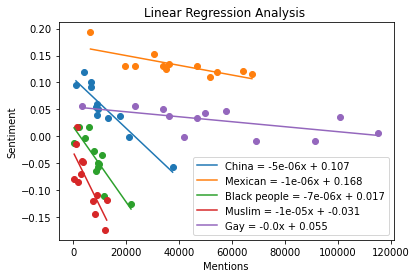

In [333]:
correlationCount = 0
plt.title("Linear Regression Analysis ")
plt.ylabel('Sentiment')
plt.xlabel('Mentions')
for j in range(0,len(keyWords)):
    x_2,y = zip(*mentionsKeyword[keyWords[j]])
    x_1,=zip(*(remappedData[j]))
    x_2 = list(x_2)
    x_1 = list(x_1)
    nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    nanArray = np.flip(np.unique(nanArray),axis=None)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 
    for i in (nanArray):

        x_2.pop(i)
        x_1.pop(i)
    if len(x_1)>2:
        pval,correlation = pearsonr(x_1,x_2)[1],pearsonr(x_1,x_2)[0]
        phrase = topKeys[j]
        if (pval <.05 and correlation < -.3):
            correlationCount+=1
            
            print('||' + topKeys[j] + '|| sentiment vs mentions p-val:' + str(round(pval,5)) + ' correlation:'+ str(round(correlation,3)))
            model = scipy.stats.linregress(x_2,x_1)
            slope = model.slope
            intercept = model.intercept
            stringLine = str(str(topKeys[j]) + ' = ' + str(round(slope,6)) + 'x + ' + str(round(intercept,3)))
            x = np.linspace(min(x_2),max(x_2),100)
            plt.plot(x,slope*x+intercept,label=stringLine)
            plt.legend()

            plt.scatter(x_2,x_1)

            phrase =phrase.upper()
            if len(trendAnalysis[trendAnalysis['Phrase'] == (phrase)]):
                # get the row number containing the phrase
                total_presence = ((trendAnalysis[trendAnalysis['Phrase'] == phrase]))
                total_presence = total_presence.index[0]
                trendAnalysis.at[total_presence,'Frequency']+=1
            else:
                row = [phrase,1,[county]]
                trendAnalysis.loc[len(trendAnalysis.index)] = row
print(str(int(round(correlationCount/len(keyWords),2)*100)) + '% of keywords tested agree with the hypothesis')



### Plotting the data
*Unlike the previous notebook's plotter, this was largely straight forward*

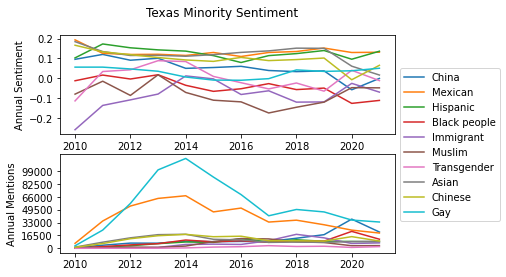

<Figure size 1080x2160 with 0 Axes>

In [336]:
maxTweets = [x for x in maxTweets if math.isnan(x) == False]
maxSentiment = np.asarray(maxSentiment).flatten()
maxSentiment = maxSentiment[~np.isnan(maxSentiment)]
maxSentScore = maxSentiment.max()
minSentScore = maxSentiment.min()
fig, (ax1,ax2) = plt.subplots(2)
if county == '':
    county = 'Texas'
fig.suptitle(county.capitalize() + ' Minority Sentiment')
ax1.set_ylabel('Annual Sentiment')
ax2.set_ylabel('Annual Mentions')
ax1.set_yticks(np.arange(round(minSentScore-.1,1), round(maxSentScore+.1,1), .1))
ax2.set_yticks(np.arange(0, np.amax(maxTweets), round(np.amax(maxTweets)/7,-2)))
for i in range(len(topKeys)):topKeys[i] = topKeys[i].capitalize()
for j in range(0,len(remappedData)):
    x_2,y = zip(*mentionsKeyword[keyWords[j]])
    x_1,=zip(*(remappedData[j]))
    x_2 = list(x_2)
    x_1 = list(x_1)
    ax1.plot(yearList,x_1,label = topKeys[j])
    ax2.plot(y,x_2)
    # nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    # nanArray = np.flip(np.unique(nanArray),axis=None)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 



plt.figure(figsize=(15,30))
fig.legend(loc="center left", bbox_to_anchor=(.9,0.5), ncol=1)
fig.savefig('Texas Cumulitive Minority Analysis.png',dpi = 100,facecolor='w', edgecolor='w',orientation='landscape',transparent=False, bbox_inches='tight', pad_inches=0.1)
# make some sort of normalizing function for the popularity of the keywords
print()

## Mass Analysis file
*OverallTrendAnalysis.py is code identical to this one, however it has been optimized in slight ways to work better with every single county pair*
- The goal of the mass analysis was to identify on a county level, what trends occured. This doesn't invalidate the larger scale trends on a state level, but the trends on a county level may serve to help identify the cause of a trend. 
- the result of the mass analysis was saved to *"overallTrendAnalysis.csv"*


Regression analysis

Facebook posts

multimethod dohickey

